In [18]:
import numpy as np
import pandas as pd
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from matplotlib import pyplot as plt
from numpy.random import seed

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

In [3]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [4]:
df = pd.read_excel('Bankruptcy_Data.xlsx', sheet_name = 'Data_final')

In [5]:
df.head()

,Global Company Key,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,...,Employee Growth,P/B,Sales/Stockholder Equity,TD/TA,Net Income Growth,ROA,Investment Turnover,Net Profit Margin,Sales/Working Capital,BK
0,1004,1979,0.98,1.58,0.36,0.18,0.13,1.33,1.77,0.07,...,NaN,0.940704,5.085936,0.651807,NaN,0.050449,2.803481,2.848787,4.958319,0
1,1004,1980,0.98,1.41,0.36,0.19,0.12,1.31,1.59,0.07,...,0.040179,0.938908,4.457522,0.642239,-0.030906,0.043407,2.493967,2.721879,4.400811,0
2,1004,1981,0.87,0.31,0.32,0.13,0.08,1.03,1.55,0.05,...,0.566524,0.650449,4.146901,0.626732,-0.660288,0.010778,2.449001,0.696323,4.768880,0
3,1004,1982,1.13,0.71,0.28,0.14,0.08,0.80,1.39,0.06,...,-0.095890,1.341751,3.586027,0.611593,1.281633,0.025115,2.322918,1.803156,5.016862,0
4,1004,1983,1.26,0.75,0.41,0.13,0.08,0.20,1.30,0.06,...,0.053030,1.444616,2.192292,0.409122,0.605367,0.032697,1.888574,2.524162,3.184386,0


In [6]:
df_train = df[df['Data Year - Fiscal'] < 2008]
df_test = df[df['Data Year - Fiscal'] >= 2008]
#df_test = df_test[df_test['Data Year - Fiscal'] <= 2016]

df_train = df_train.dropna()
df_test = df_test.dropna()

print(df_train.shape)
print(df_test.shape)

(44804, 23)
(36365, 23)


In [7]:
df_train["BK"].value_counts()

0    44389
1      415
Name: BK, dtype: int64

In [8]:
df_test["BK"].value_counts()

0    36307
1       58
Name: BK, dtype: int64

In [9]:
col = ['EPS','Liquidity','Profitability','Productivity','Leverage Ratio','Asset Turnover','Operational Margin',
      'Assets Growth','Sales Growth','Employee Growth','ROE','P/B','Net Income Growth',
        'Investment Turnover','Sales/Working Capital','ROA']

Y_test = np.array(df_test['BK'])
Y_train = np.array(df_train['BK'])
#df1 = dftrain.drop(columns=['Data Year - Fiscal','TobinsQ','BK'])
#df2 = dftest.drop(columns=['Data Year - Fiscal','TobinsQ','BK'])
X_train = np.array(df_train[col])
X_test = np.array(df_test[col])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(44804, 16)
(44804,)
(36365, 16)
(36365,)


In [10]:
df_train["BK"].value_counts()

0    44389
1      415
Name: BK, dtype: int64

In [11]:
#os = RandomUnderSampler(sampling_strategy = 1, replacement = True)
os = RandomOverSampler(sampling_strategy = 'minority')
#os = SMOTE(sampling_strategy = 'minority')
data_X,data_Y=os.fit_resample(X_train, Y_train)

In [12]:
print(data_X.shape)
print(data_Y.shape)

(88778, 16)
(88778,)


In [13]:
data_X = pd.DataFrame(data = data_X,columns = col )
data_Y = pd.DataFrame(data = data_Y,columns=['Bankrupt'])

In [14]:
data_Y["Bankrupt"].value_counts()

1    44389
0    44389
Name: Bankrupt, dtype: int64

In [15]:
# Feature Scaling

X_train = np.array(data_X)
Y_train = np.array(data_Y)
sc = preprocessing.StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test  = sc.transform(X_test)

# Boosting

In [19]:
clf_boost = AdaBoostClassifier()
clf_boost.fit(X_train, Y_train.ravel())

AdaBoostClassifier()

In [20]:
boost_train_predict = clf_boost.predict(X_train)

In [21]:
print("f1_score on the training set: %f" % f1_score(Y_train, boost_train_predict, average="weighted"))

f1_score on the training set: 0.875956


In [22]:
#COmputing mean of the five fold cross validation score
sc = cross_val_score(clf_boost, X_train, Y_train.ravel(),scoring="accuracy", cv=5)
print("Cross Validation scores: ", sc)
print("Cross Validation scores mean: ", sc.mean())

Cross Validation scores:  [0.89687993 0.89141699 0.87801307 0.84843706 0.82444382]
Cross Validation scores mean:  0.8678381716701805


In [20]:
def plot_learning_curve(estimator,title,X,y,axes=None,ylim=None,cv=None,n_jobs=None,
                        train_sizes=np.linspace(0.1, 1.0, 5),):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,
        train_sizes=train_sizes,scoring="f1_weighted",return_times=True,)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [24]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {
    'base_estimator__max_depth': [1, 2, 3, None],
    "base_estimator__splitter" : ["best", "random"],
    'n_estimators': [25, 50, 100],
    'base_estimator__criterion': ['gini', 'entropy']
}
empty_decision_tree = DecisionTreeClassifier(max_depth=None)
estimator = AdaBoostClassifier(empty_decision_tree)


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 1, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, Y_train.ravel())

#First grid search
grid1 = grid_search.best_estimator_
f1_score1 = grid_search.best_score_
print("Best estimator: ", grid1)
print("\n")
print("Best f1 score: ", f1_score1)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 24.7min finished


Best estimator:  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(splitter='random'),
                   n_estimators=25)


Best f1 score:  0.9948744166774945


In [25]:
param_grid = {
    'base_estimator__max_depth': [1, 2],
    'learning_rate': [0.01, 0.05, 0.1],
    "base_estimator__splitter" : ["best"],
    'n_estimators': [10, 20, 30],
    'base_estimator__criterion': ['gini']
}
empty_decision_tree = DecisionTreeClassifier(max_depth=None)
adaboost = AdaBoostClassifier(empty_decision_tree)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = adaboost, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train, Y_train.ravel())

#Second grid search
grid2 = grid_search.best_estimator_
f1_score2 = grid_search.best_score_
print("Best estimator: ", grid_search.best_estimator_)
print("\n")
print("Best f1 score: ", f1_score2)

Best estimator:  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=30)


Best f1 score:  0.8502678576801846


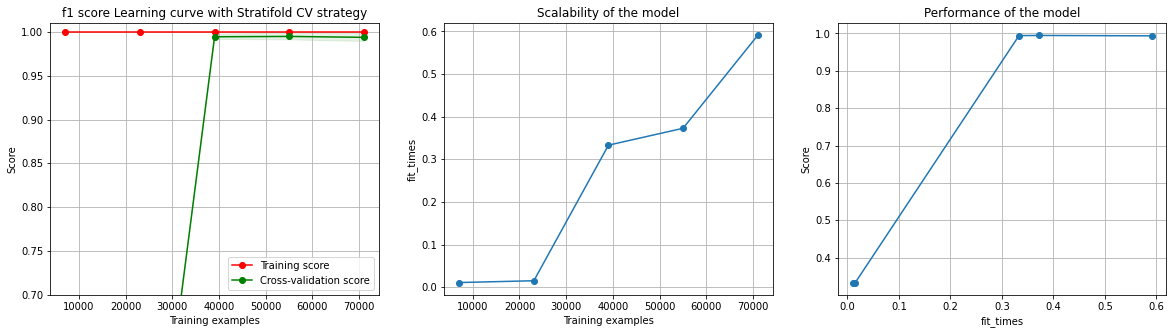

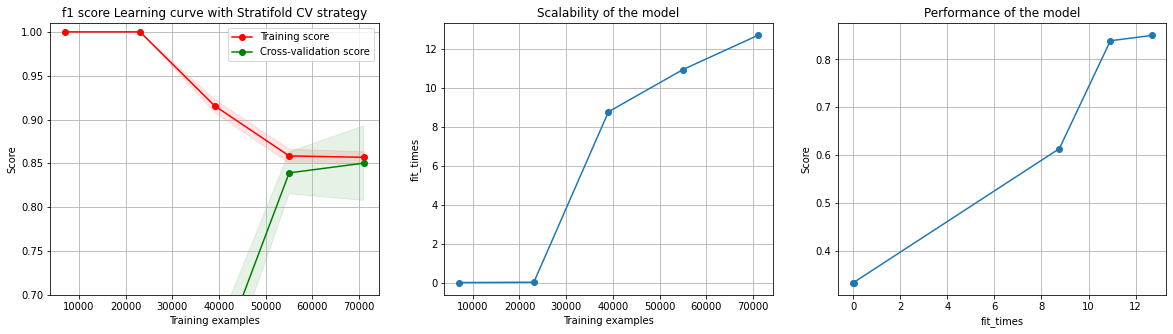

In [28]:
#Choose the best f1 score
estimators = [grid1, grid2]
for estimator in estimators:
    
    #Shuffle Split = Stratifold strategy
    title1 = "f1 score Learning curve with Stratifold CV strategy"
    plot_learning_curve(estimator, title1, X_train, Y_train.ravel(), axes=None, ylim=(0.7, 1.01),
                    cv=None, n_jobs=-1)

In [39]:
def complexity_curve(train_scores, validation_scores, index, title, inverse_x=False):
    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(index, train_scores , "r-+",label="Train")
    plt.plot(index, test_scores, "g-+",label="Validation")
    plt.title(title)
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    #plt.gca().invert_xaxis()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.6min finished


[0.82649507 0.83590866 0.85389336 0.85691146 0.87418417] [0.81982773 0.83334869 0.84765332 0.85026786 0.86750366] [5, 10, 25, 30, 50]


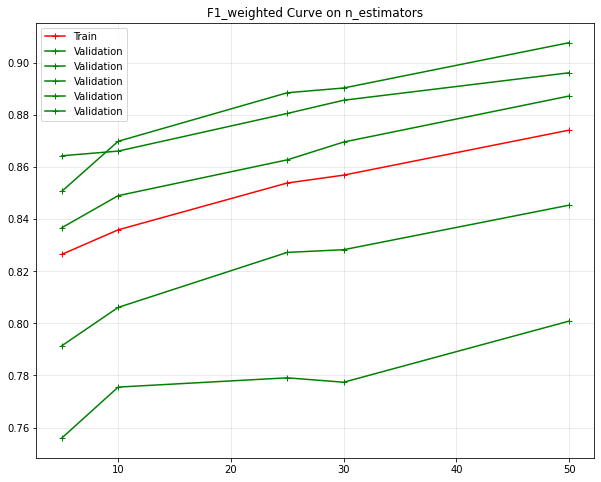

In [40]:
#Using the validation curve determine the best alpha
boosted_tree = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         splitter='best'),
                   learning_rate=0.1, n_estimators=30)
param_range = [5,10,25,30,50]
train_scores, test_scores = validation_curve(boosted_tree, X_train, Y_train.ravel(), param_name="n_estimators", 
    param_range=param_range, scoring='f1_weighted', verbose=1, cv=5, n_jobs=-1)
print(train_scores.mean(axis=1), test_scores.mean(axis=1), param_range)
complexity_curve(train_scores.mean(axis=1), test_scores.mean(axis=1), param_range, 
                title='F1_weighted Curve on n_estimators', inverse_x=False)

<module 'matplotlib.pyplot' from 'c:\\users\\aniru\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

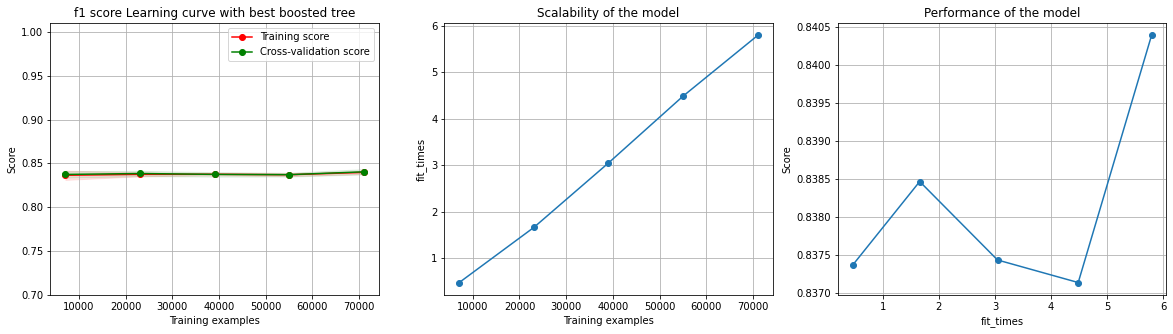

In [21]:
#Determining the best boosted tree
clf_boost = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=DecisionTreeClassifier(criterion='gini',
                                                         max_depth=2,
                                                         splitter='best'),learning_rate=0.1, n_estimators=10)


#Shuffle Split with stratifold
title2 = "f1 score Learning curve with best boosted tree"
cv_dT= ShuffleSplit(test_size=0.2, random_state=0)
plot_learning_curve(clf_boost, title2, X_train, Y_train.ravel(), axes=None, ylim=(0.7, 1.01),
                cv=cv_dT, n_jobs=-1)

In [22]:
clf_boost.fit(X_train, Y_train.ravel())
predict_decision = clf_boost.predict(X_test)


#Print results
print(classification_report(Y_test, predict_decision))
print("f1 score: ", f1_score(Y_test, predict_decision, average="weighted"))
print()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(Y_test, predict_decision).flatten()
type_I_error_test = (1 - (tp_test/(tp_test+fn_test))) * 100
type_II_error_test = (1 - (tn_test/(tn_test+fp_test))) * 100
print("True Negative, False Positive, False Negative, True Positive: ", tn_test, fp_test, fn_test, tp_test)
print()
print("Type I error: ", type_I_error_test)
print("Type II error: ", type_II_error_test)
print()
      
probs_dc = clf_boost.predict_proba(X_test)
probs_dc = probs_dc[:, 1]
auc = roc_auc_score(Y_test, probs_dc)
print('AUC: %.3f' % auc)

              precision    recall  f1-score   support

           0       1.00      0.78      0.87     36307
           1       0.01      0.90      0.01        58

    accuracy                           0.78     36365
   macro avg       0.50      0.84      0.44     36365
weighted avg       1.00      0.78      0.87     36365

f1 score:  0.8733907218248977

True Negative, False Positive, False Negative, True Positive:  28230 8077 6 52

Type I error:  10.344827586206895
Type II error:  22.24639876607817

AUC: 0.901
